# Version 1.0 Model Predictions

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import RobustScaler 

## Import Data Sets
Here we will import `NetC_Expanded` which is data seperated by management style, result and slavage status, and we will import the predictors and join those datasets.

In [2]:
netc_expanded = pd.read_csv('../Data/NetC_Expanded.csv')
netc_expanded = netc_expanded.drop(['Unnamed: 0'], axis=1)
netc_expanded.head()

,TimeStep,Risk_Cat,Stand_ID,Salvage,Management,Result
0,0,4,0023200606030102900043,True,Heavy,-249.287884
1,0,4,0023200606030102900043,True,NoMgmt,-321.931519
2,0,4,0023200606030102900043,True,Moderate,-276.111511
3,0,4,0023200606030102900043,True,Comm-Ind,-250.583375
4,0,4,0023200606030102900043,True,HighGrade,-293.426896


In [3]:
predictors = pd.read_csv('../Data/Predict_SBW_wCarbon_T0to40.csv')
predictors = predictors.rename(columns={'StandID': 'Stand_ID'})
predictors = predictors.set_index('Stand_ID')
predictors = predictors[["BF_BA","OHost_BA","BF_Stock","OHost_Stock","NonHost_Stock","BF_QMD","ELEV","SLOPE","ASPECT","LAT","SiteInd"]]
predictors.head()

,BF_BA,OHost_BA,BF_Stock,OHost_Stock,NonHost_Stock,BF_QMD,ELEV,SLOPE,ASPECT,LAT,SiteInd
Stand_ID,,,,,,,,,,,
0023200606030200300067,NaN,0.498332,NaN,0.883600,56.9255,NaN,580,5.0,240.0,46.14358,NaN
0023200606030200300826,3.899610,11.890484,21.8437,0.885569,18.6635,4.965398,1170,0.0,0.0,47.19684,28.0
0023200606030200300924,0.036869,7.443510,0.2679,1.166825,3.8019,2.600000,990,0.0,0.0,46.64171,33.0
0023200606030301901813,0.967649,1.368845,63.7216,1.609179,12.1858,2.106063,180,0.0,0.0,45.09319,40.0
0023200606030400901513,3.352901,6.679677,73.4189,1.397641,18.2434,3.405766,250,0.0,0.0,44.73563,NaN


## Selecting Management Style 
Gong to define a management style upfront to create rule set

In [4]:
MANAGEMENT_STYLE = 'NoMgmt'

mgmt_df = netc_expanded[netc_expanded['Management'] == MANAGEMENT_STYLE]

### Apply Discount Rate
Didn't have time to make a "smart" implimentation of this. 

In [5]:
discount_rate = lambda diff, t: diff * (1 / (1 + 0.02) ** t)

In [6]:
def discount(df):
    ## Initialize df
    temp_df = df.copy()
    temp_df = temp_df.sort_values(by=['Stand_ID', 'TimeStep'])
    
    ## Define discount rate
    discount_rate = lambda diff, t: diff * (1 / (1 + 0.01) ** t)
#     discount_rate = lambda diff, t: diff * 1
    for i, row in temp_df.iterrows():
        
        ## If first timestep do nothing
        if row['TimeStep'] == 0:
            continue
            
        diff = row['Result'] - temp_df.loc[(temp_df['TimeStep'] == (row['TimeStep'] - 10)) 
                                           & (temp_df['Salvage'] == row['Salvage']) &
                                           (temp_df['Stand_ID'] == row['Stand_ID']), 'Result'].values[0]
        
        base = temp_df.loc[(temp_df['TimeStep'] == 0) & 
                   (temp_df['Salvage'] == row['Salvage']) &
                   (temp_df['Stand_ID'] == row['Stand_ID']), 'Result'].values[0]
    
        discounted_result = discount_rate(diff, row['TimeStep']) + base
        
        ## update df
        temp_df.at[i, 'Result'] = discounted_result 
        
        
    return temp_df

In [7]:
discount_df = discount(mgmt_df)

In [8]:
def get_mgmt_df(target_df, pred_df, tol):
    """
    Returns labeled DF for salvage and non salvage decisions
    """
    temp_df = pd.DataFrame(columns=['Stand_ID', 'Give_Voucher', 'Result'])
    for stand in target_df['Stand_ID'].unique():
        
        group_df = target_df[(target_df['Stand_ID'] == stand)
                             & (target_df['TimeStep'] == 40)]
        group_df = group_df.set_index('Salvage')
        
        assert group_df.shape[0] == 2
        
        # calculate diff
        diff =  group_df.at[True, 'Result'] - group_df.at[False, 'Result']
        
        #  If index is True where min is acheived
        if group_df['Result'].idxmin():  # and diff > tol:
            temp_df = temp_df.append(
                pd.DataFrame({
                    'Stand_ID': [stand],
                    'Give_Voucher': [0],
                    'Result': [group_df['Result'].min()],
                    'Diff': [diff]
                })
            )
        else:
            temp_df = temp_df.append(
                pd.DataFrame({
                    'Stand_ID': [stand],
                    'Give_Voucher': [1],
                    'Result': [group_df['Result'].min()],
                    'Diff': [diff]
                })
            )
            
    temp_df = temp_df.set_index('Stand_ID')
    return pd.merge(pred_df, temp_df, on="Stand_ID", right_index=True)

In [9]:
heavy_df = get_mgmt_df(discount_df, predictors, 0)
heavy_df = heavy_df.fillna(heavy_df.median())
# heavy_df[heavy_df['Give_Voucher'] == True].assign(percent_improvement=heavy_df['diff'] / (heavy_df['Result'] - heavy_df['diff'])).describe()
heavy_df.head()

,BF_BA,OHost_BA,BF_Stock,OHost_Stock,NonHost_Stock,BF_QMD,ELEV,SLOPE,ASPECT,LAT,SiteInd,Give_Voucher,Result,Diff
Stand_ID,,,,,,,,,,,,,,
0023200606030200300067,2.325367,0.498332,11.4585,0.883600,56.9255,5.490730,580,5.0,240.0,46.14358,42.0,0,-450.901607,-5.670283
0023200606030200300826,3.899610,11.890484,21.8437,0.885569,18.6635,4.965398,1170,0.0,0.0,47.19684,28.0,1,-421.994495,30.713591
0023200606030200300924,0.036869,7.443510,0.2679,1.166825,3.8019,2.600000,990,0.0,0.0,46.64171,33.0,0,-341.444464,-4.378991
0023200606030301901813,0.967649,1.368845,63.7216,1.609179,12.1858,2.106063,180,0.0,0.0,45.09319,40.0,0,-469.271833,-68.085650
0023200606030400901513,3.352901,6.679677,73.4189,1.397641,18.2434,3.405766,250,0.0,0.0,44.73563,42.0,1,-382.929237,10.305352


### How much is saved on average when a voucher is given normally? 

We can see here the differences in balance of the data. 

In [138]:
heavy_df['Give_Voucher'].value_counts() / heavy_df.shape[0]

0    0.597442
1    0.402558
Name: Give_Voucher, dtype: float64

There is lots of variablility in the `Give_Voucher` variable, which could be why it is tough to predict.

In [137]:
heavy_df.groupby('Give_Voucher').agg({'Diff': [np.mean, np.std, np.min, np.max]})

Diff                                   
                   mean        std        amin        amax
Give_Voucher                                              
0            -31.054011  28.453762 -256.762804   -0.002295
1             26.203947  30.641739    0.003393  287.919027

## Split Data

In [190]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [191]:
X_scaler = RobustScaler()

In [192]:
X = heavy_df.drop(['Give_Voucher', 'Result', 'Diff'], axis=1)
y = heavy_df[['Give_Voucher']].astype('int')

X[X.columns] = X_scaler.fit_transform(X[X.columns])

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Baselines

`IP` is an interpretability constant since net saved emissions is always large

In [105]:
assess_df = mgmt_df.set_index('Stand_ID')
assess_df = assess_df[assess_df['TimeStep'] == 40]
assess_df = assess_df[['Salvage', 'Result']]

assess_df = pd.merge(assess_df, X_test, on="Stand_ID")

### (1) Don't Salvage At All

In [106]:
no_salvage = assess_df[(assess_df['Salvage'] == False)]
no_salvage_score = no_salvage['Result'].mean()
# no_salvage_score / assess_df.shape[0]
no_salvage_score

-607.4202291208925

### (2) Only Salvage

In [107]:
only_salvage = assess_df[(assess_df['Salvage'] == True)]
only_salvage_score = only_salvage['Result'].mean()
# only_salvage_score / assess_df.shape[0]
only_salvage_score

-660.8691479991785

### (3) Optimal

In [108]:
(assess_df
 .reset_index('Stand_ID')
 .groupby('Stand_ID')
 .agg({'Result': np.min})
 .Result.mean())

-663.79284076643

## SKOPE Rules

In [204]:
from imodels import SkopeRulesClassifier
from imodels import BayesianRuleListClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

### Training

In [82]:
try:
    X_train = X_train.drop(['Diff'], axis=1)
    X_test = X_test.drop(['Diff'], axis=1)
except KeyError:
    pass

In [205]:
import scipy

In [7]:
parameters = {'precision_min':[x for x in range(1 // 10)],
              'recall_min':[x for x in range(1 // 10)],
              'n_estimators':[x for x in range(0, )],
              'max_samples':[x for x in range(0.1, 1, 0.1)],
              'bootstrap':[True, False], 
              'bootstrap_features':[True, False]}

In [207]:
clf = SkopeRulesClassifier(
    max_depth_duplication=1000,
    n_estimators=200,
    precision_min=0.6,
    recall_min=0.01
)
clf.fit(X_train, y_train.to_numpy().ravel())

SkopeRulesClassifier(max_depth_duplication=1000, n_estimators=200,
                     precision_min=0.6)

In [208]:
y_train_pred = clf.predict_top_rules(X_train, 7)
accuracy_score(y_train, y_train_pred)

0.7284263959390863

In [209]:
y_pred = clf.predict_top_rules(X_test, 7)
accuracy_score(y_test, y_pred)

0.6805273833671399

### Assessing Rules

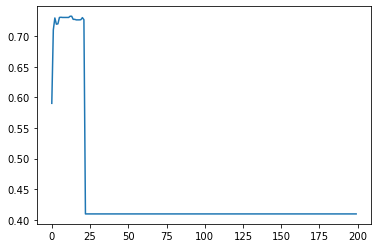

In [86]:
def show_rules():
    """ 
    plot rules over time
    """
    preds = [accuracy_score(y_train, clf.predict_top_rules(X_train, i)) for i in range(200)]
    plt.plot([i for i in range(len(preds))],  preds)

show_rules()

In [87]:
for rule in clf.rules_[:5]:
    print(rule)

('feature_1 > -0.004575850209221244 and feature_3 > -0.2513926178216934 and feature_5 > -0.1509597972035408', (0.6380090497737556, 0.5071942446043165, 1))
('feature_1 > -0.40605269372463226 and feature_4 <= 0.0348536167293787 and feature_5 > -0.15053022652864456', (0.6954314720812182, 0.4612794612794613, 1))
('feature_1 <= 1.5276544094085693 and feature_1 > -0.004575850209221244 and feature_5 > -0.15053022652864456', (0.6096491228070176, 0.5054545454545455, 1))
('feature_1 > 1.0067852139472961 and feature_5 > -0.15748726576566696', (0.8777777777777778, 0.2651006711409396, 1))
('feature_1 > 1.0040240287780762 and feature_3 > -0.30563437938690186', (0.773936170212766, 0.26515151515151514, 2))


In [210]:
def print_columns(X, cols):
    print("RULES LEARNED: ")
    for col in cols:
        print("feature_{} is {}".format(col, X_train.columns[col]))
        
        
# print_columns(X_test, [2, 3, 4, 5, 6, 9])
print_columns(X_test, [1, 3, 4, 5])


RULES LEARNED: 
feature_1 is OHost_BA
feature_3 is OHost_Stock
feature_4 is NonHost_Stock
feature_5 is BF_QMD


### Counts for Classess in Classification
This is here to make sure no problems occur learning to predict only salvaging

In [89]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([559, 427]))

In [90]:
y_train.value_counts() / y_train.shape[0]

Give_Voucher
0               0.590243
1               0.409757
dtype: float64

In [91]:
y_test.value_counts() / y_test.shape[0]

Give_Voucher
0               0.625761
1               0.374239
dtype: float64

### (4) Skope Rules (assess savings)

In [92]:
from sklearn.metrics import precision_score, recall_score

In [93]:
def assess_savings(X_test, y_pred):
    """
    Append predicitons and sum slavage/no salvage results 
    """
    # add predictions
    test_df = X_test.copy()
    test_df['preds'] = y_pred

    # merge with management 
    temp = pd.merge(assess_df, test_df, on="Stand_ID")

    salvage_sum = temp[(temp['Salvage'] == True) & (temp['preds'] == 1)].Result.mean()
    no_salvage_sum = temp[(temp['Salvage'] == False) & (temp['preds'] == 0)].Result.mean()

    return (salvage_sum + no_salvage_sum) / 2

In [94]:
skope_rules_score = assess_savings(X_test, y_pred)
skope_rules_score

-640.4371694191611

In [95]:
precision_score(y_test, y_pred)

0.6112412177985949

In [96]:
recall_score(y_test, y_pred)

0.7073170731707317

---

### SVM 

In [200]:
from sklearn.svm import SVC 
from sklearn.pipeline import make_pipeline

In [201]:
temp = SVC()
temp.fit(X_train, y_train)
y_pred = temp.predict(X_test)
accuracy_score(y_test, y_pred)

/home/sean/anaconda3/envs/optimization/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7434077079107505

In [202]:
precision_score(y_test, y_pred)

0.7427745664739884

In [203]:
recall_score(y_test, y_pred)

0.6104513064133017

In [198]:
from sklearn.model_selection import GridSearchCV

In [211]:
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'] , 
              'C':[1, 10, 100], 'gamma':[0.01, 0.001, 0.0001], 'degree':[1,2,3,4,5],
              'class_weight':[None, 'balanced']}

parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'] , 
              'C':[1, 10, 100], 'gamma':[0.01, 0.001, 0.0001], 'degree':[1,2,3,4,5],
              'class_weight':[None, 'balanced']}

svc = SVC()
search_svc = GridSearchCV(svc, parameters, n_jobs=3)

search_svc.fit(X_train, y_train)

/home/sean/anaconda3/envs/optimization/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=SVC(), n_jobs=3,
             param_grid={'C': [1, 10, 100], 'class_weight': [None, 'balanced'],
                         'degree': [1, 2, 3, 4, 5],
                         'gamma': [0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [212]:
search_svc_preds = search_svc.predict(X_test)
accuracy_score(y_test, search_svc_preds)

0.7373225152129818

In [213]:
precision_score(y_test, search_svc_preds)

0.7410714285714286

In [214]:
recall_score(y_test, search_svc_preds)

0.5914489311163895

In [216]:
search_svc.__dict__

{'scoring': None,
 'estimator': SVC(),
 'n_jobs': 3,
 'iid': 'deprecated',
 'refit': True,
 'cv': None,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'C': [1, 10, 100],
  'gamma': [0.01, 0.001, 0.0001],
  'degree': [1, 2, 3, 4, 5],
  'class_weight': [None, 'balanced']},
 'multimetric_': False,
 'best_index_': 122,
 'best_score_': 0.7685279187817259,
 'best_params_': {'C': 10,
  'class_weight': None,
  'degree': 1,
  'gamma': 0.01,
  'kernel': 'rbf'},
 'best_estimator_': SVC(C=10, degree=1, gamma=0.01),
 'refit_time_': 0.26038098335266113,
 'scorer_': <function sklearn.metrics._scorer._passthrough_scorer>,
 'cv_results_': {'mean_fit_time': array([0.17000203, 0.09300423, 0.16101079, 0.16491752, 0.16529136,
         0.10575566, 0.18211908, 0.18974738, 0.16789556, 0.11381292,
         0.20718203, 0.20639606, 0.16545625, 0.1108788 , 0.15895205,
         0.16624174, 0.16472297, 

In [194]:
from sklearn.linear_model import LogisticRegression

In [195]:
temp = LogisticRegression()
temp.fit(X_train, y_train)
preds = temp.predict(X_test)
accuracy_score(y_test, preds)

/home/sean/anaconda3/envs/optimization/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.7079107505070994

In [196]:
precision_score(y_test, preds)

0.7084639498432602

In [197]:
temp.__dict__

{'penalty': 'l2',
 'dual': False,
 'tol': 0.0001,
 'C': 1.0,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'class_weight': None,
 'random_state': None,
 'solver': 'lbfgs',
 'max_iter': 100,
 'multi_class': 'auto',
 'verbose': 0,
 'warm_start': False,
 'n_jobs': None,
 'l1_ratio': None,
 'n_features_in_': 11,
 'classes_': array([0, 1]),
 'coef_': array([[-0.16795963,  1.08733314, -0.17893773,  0.12781963, -0.29533896,
          0.84516336,  0.17625477,  0.04909647,  0.00800877, -0.3456233 ,
         -0.4232954 ]]),
 'intercept_': array([-0.55710496]),
 'n_iter_': array([16], dtype=int32)}

In [189]:
X_train.columns

Index(['BF_BA', 'OHost_BA', 'BF_Stock', 'OHost_Stock', 'NonHost_Stock',
       'BF_QMD', 'ELEV', 'SLOPE', 'ASPECT', 'LAT', 'SiteInd', 'Diff'],
      dtype='object')